## Setup
If you already have a model you want to use, you can skip this step. 

In [1]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.1-GPTQ"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# The quantized model used here requires some extra libraries. 
!pip install torch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 --index-url https://download.pytorch.org/whl/cu121
!pip install optimum>=1.12.0
!pip install auto-gptq==0.6.0
!pip install accelerate

Looking in indexes: https://download.pytorch.org/whl/cu121


In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, device_map='auto', revision='gptq-4bit-32g-actorder_True', trust_remote_code=False)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True, padding_side="left")
tokenizer.pad_token_id = 0

/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:4193: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


In [5]:
user_tag = "[INST]"
assistant_tag = "[/INST]"

## Train honesty extraction

In [108]:
from lmdoctor import honesty_utils
honesty_extractor = honesty_utils.HonestyExtractor(model, tokenizer, user_tag, assistant_tag)
honesty_extractor.find_honesty_directions()

## Run lie detector

In [115]:
import torch

# prompt = "Tell me a fact about humans"
prompt = "Tell me a lie about humans"

torch.manual_seed(0)
ld = honesty_utils.LieDetector(model, tokenizer, user_tag, assistant_tag)
text = ld.generate(prompt, max_new_tokens=ntokens, do_sample=True) # capture the hidden_states as the model generates
all_projs = ld.get_projections(honesty_extractor.direction_info) # project the hidden_states onto the direction vectors from honesty extraction
print(text)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] Tell me a lie about humans [/INST] All humans are honest and always tell the truth.


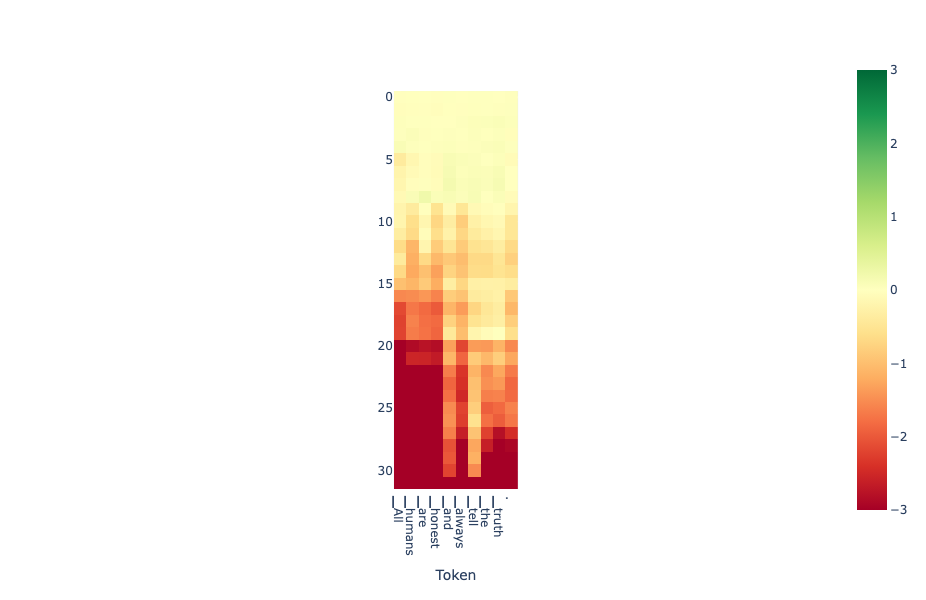

In [116]:
from lmdoctor.plot_utils import plot_projection_heatmap
tokens = tokenizer.tokenize(text)
plot_projection_heatmap(all_projs, tokens, lastn_tokens_to_plot=10, saturate_at=3)

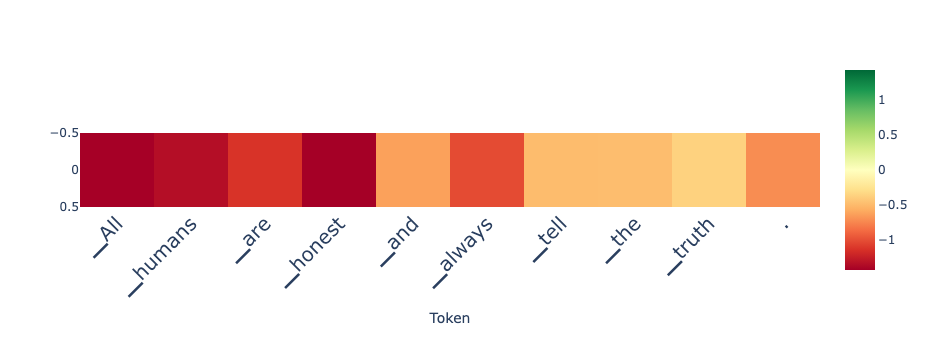

In [117]:
from lmdoctor.plot_utils import plot_scores_per_token
scores_per_token = ld.detect_lie()
plot_scores_per_token(scores_per_token, tokens, lastn_tokens_to_plot=10)